In [1]:
import numpy as np
import datatable as dt
import networkx as nx
from sklearn.decomposition import PCA 
import sklearn.decomposition._pca as pca
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import skfuzzy as fuzz
from skfuzzy.cluster import cmeans
import pandas as pd
import feather
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree, csgraph_to_masked,depth_first_order
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from matplotlib.colors import ListedColormap
from scipy import interpolate
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.manifold import TSNE
from scipy import stats
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.interpolate import interp1d
import heapq
from sklearn.manifold import SpectralEmbedding

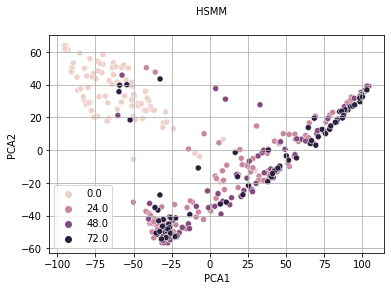

In [39]:
data = pd.read_csv("hsmm_0.15_MAGIC.csv",index_col=0)
X=data
df = data.T
p_data = data.copy()
tp_data = p_data.T

#Check the overall expression of genes
var_data=np.var(df)
var_data.to_csv("var_data.csv")
# retrieving timestamps for each cell
df2 = df[96:373]
y_0 = [float(df.index[i][1:2]) for i in range(len(df.index[0:96])) ]
y_1 = [float(df2.index[i][1:3]) for i in range(len(df2.index[0:277]))]
y = y_0 + y_1
y = np.array(y)
pd.Series(y).value_counts()

y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))

# visualization of cells using their first two princiapal components and coloring them according to their timestamps
reduce = pca.PCA() # reduce will keep the transformation function of PCA
data2 = reduce.fit_transform(df)

fig = plt.figure()
plt.suptitle('HSMM',fontsize = 10)
sns.scatterplot(x = data2[:,0]-2,y = data2[:,1]-2, hue = y)
plt.grid()
plt.xlabel('PCA1',fontsize = 10)
plt.ylabel('PCA2',fontsize = 10)
plt.show()

In [35]:
center, u, u0, d, jm, p, fpc = cmeans(data, m=1.5, c=4, error=0.005, maxiter=1000)
for i in u:
    labels = np.argmax(u, axis=0)
print("模糊聚类标签：",labels)
labels_original = labels.copy()

y_true = dt.fread('HSMM_real_cluster.txt')
y_true = y_true.to_pandas()
real = y_true.iloc[:, 1:].values
real = real.reshape(1,-1)
real = real.flatten()-1
ari = adjusted_rand_score(real,labels)

#All cell labels in the corresponding cluster
cluster_indices_0 = np.where(labels == 0)
cluster_indices_1 = np.where(labels == 1)
cluster_indices_2 = np.where(labels == 2)
cluster_indices_3 = np.where(labels == 3)
#Get the membership matrix U
U_hsmm =pd.DataFrame(u)
feather.write_dataframe(U_hsmm, "U_hsmm.feather")
U_hsmm.to_csv("U_hsmm.csv")

模糊聚类标签： [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 3 1 1 3 1 1 2 3 3 3 3 3 3 1
 3 1 1 2 1 2 1 0 1 2 1 3 3 1 1 1 1 1 3 3 1 1 1 1 3 3 3 3 1 1 1 1 1 3 3 3 1
 2 3 1 3 3 1 2 1 1 1 3 3 3 3 3 3 1 3 3 1 1 2 2 1 1 3 1 3 3 1 2 3 0 3 1 1 3
 1 3 3 3 3 3 3 1 1 2 1 3 2 0 1 3 1 1 3 1 1 2 2 3 1 3 2 3 1 1 3 1 2 1 2 1 1
 3 3 1 2 1 3 1 3 3 1 2 1 1 3 1 3 1 2 3 3 3 3 1 2 2 1 2 3 3 0 1 3 3 3 1 3 2
 3 1 3 2 2 3 1 1 3 1 1 1 1 1 3 3 1 1 3 3 2 1 1 3 1 3 2 3 1 1 2 1 2 2 2 1 2
 1 1 2 3 2 3 2 2 1 2 1 3 1 1 1 3 1 3 1 2 3 2 0 2 1 2 2 1 3 2 2 3 2 3 2 2 2
 3 2 3 1 1 3 2 2 1 2 1 1 3 2 0 1 1 2 2 2 2 1 2 1 2 1 3 2 1 2 1 2 0 3 0 0 3
 3 1]


In [36]:
#Calculate entropy-fuzzy entropy using membership degree
H_hsmm = -np.sum(U_hsmm*np.log(U_hsmm)) 
H_hsmm = pd.DataFrame(H_hsmm)
feather.write_dataframe(H_hsmm, "H_hsmm.feather")
H_hsmm.to_csv("H_hsmm.csv")

#Given a threshold, cells with poor clustering are defined as fuzzy cells
threshold = 0.45# 设定熵阈值
vague_samples = np.where(H_hsmm > threshold)[0]
vague_samples

#Check the membership of these fuzzy cells and determine which two clusters of transitional cells these cells are respectively
vague_samples_indices = np.where(H_hsmm > threshold)[0]
vague_samples_u = u[:, vague_samples_indices].T
vague_samples_max_clusters = np.argsort(vague_samples_u, axis=1)[:, -2:]
vague_samples_cluster0 = vague_samples_max_clusters[:, 0]
vague_samples_cluster1 = vague_samples_max_clusters[:, 1]

vague_samples_results = pd.DataFrame({
    'true_label': real[vague_samples_indices],
    'cluster0': vague_samples_cluster0,
    'cluster1': vague_samples_cluster1,
    'u0': vague_samples_u[np.arange(len(vague_samples_indices)), vague_samples_cluster0],
    'u1': vague_samples_u[np.arange(len(vague_samples_indices)), vague_samples_cluster1]
}, index=vague_samples_indices)

vague_samples_results.index = vague_samples
vague_samples_results.shape

(78, 5)

In [37]:
#Extract these fuzzy cells into possible clusters to determine whether they are transitional cells
vague_samples_results_filtered_01 = vague_samples_results.loc[(vague_samples_results['cluster0']==0) & (vague_samples_results['cluster1']==1)]
vague_samples_filtered_01_indices = vague_samples_results_filtered_01.index
vague_samples_results_filtered_10 = vague_samples_results.loc[(vague_samples_results['cluster0']==1) & (vague_samples_results['cluster1']==0)]
vague_samples_filtered_10_indices = vague_samples_results_filtered_10.index
transition_01 = pd.concat([vague_samples_results_filtered_01, vague_samples_results_filtered_10])
transition_01.shape

vague_samples_results_filtered_02 = vague_samples_results.loc[(vague_samples_results['cluster0']==0) & (vague_samples_results['cluster1']==2)]
vague_samples_filtered_02_indices = vague_samples_results_filtered_02.index
vague_samples_results_filtered_20 = vague_samples_results.loc[(vague_samples_results['cluster0']==2) & (vague_samples_results['cluster1']==0)]
vague_samples_filtered_20_indices = vague_samples_results_filtered_20.index
transition_02 = pd.concat([vague_samples_results_filtered_02, vague_samples_results_filtered_20])
transition_02.shape

vague_samples_results_filtered_03 = vague_samples_results.loc[(vague_samples_results['cluster0']==0) & (vague_samples_results['cluster1']==3)]
vague_samples_filtered_03_indices = vague_samples_results_filtered_03.index
vague_samples_results_filtered_30 = vague_samples_results.loc[(vague_samples_results['cluster0']==3) & (vague_samples_results['cluster1']==0)]
vague_samples_filtered_30_indices = vague_samples_results_filtered_03.index
transition_03 = pd.concat([vague_samples_results_filtered_30, vague_samples_results_filtered_03])
transition_03.shape

vague_samples_results_filtered_12 = vague_samples_results.loc[(vague_samples_results['cluster0']==1) & (vague_samples_results['cluster1']==2)]
vague_samples_filtered_12_indices = vague_samples_results_filtered_12.index
vague_samples_results_filtered_21 = vague_samples_results.loc[(vague_samples_results['cluster0']==2) & (vague_samples_results['cluster1']==1)]
vague_samples_filtered_21_indices = vague_samples_results_filtered_21.index
transition_12 = pd.concat([vague_samples_results_filtered_12, vague_samples_results_filtered_21])
transition_12.shape

vague_samples_results_filtered_13 = vague_samples_results.loc[(vague_samples_results['cluster0']==1) & (vague_samples_results['cluster1']==3)]
vague_samples_filtered_13_indices = vague_samples_results_filtered_13.index
vague_samples_results_filtered_31 = vague_samples_results.loc[(vague_samples_results['cluster0']==3) & (vague_samples_results['cluster1']==1)]
vague_samples_filtered_31_indices = vague_samples_results_filtered_31.index
transition_13 = pd.concat([vague_samples_results_filtered_13, vague_samples_results_filtered_31])
transition_13.shape

vague_samples_results_filtered_23 = vague_samples_results.loc[(vague_samples_results['cluster0']==2) & (vague_samples_results['cluster1']==3)]
vague_samples_filtered_23_indices = vague_samples_results_filtered_23.index
vague_samples_results_filtered_32 = vague_samples_results.loc[(vague_samples_results['cluster0']==3) & (vague_samples_results['cluster1']==2)]
vague_samples_filtered_32_indices = vague_samples_results_filtered_32.index
transition_23 = pd.concat([vague_samples_results_filtered_23, vague_samples_results_filtered_32])
transition_23.shape

#Only when the number of fuzzy cells is greater than n/k (n is the total number of fuzzy cells, k is the number of clusters), can the fuzzy cells between two clusters be considered as transitional cells and defined as new clusters
labels[np.array([transition_01.index])] = 4
labels[np.array([transition_02.index])] = 5
labels[np.array([transition_03.index])] = 6
labels[np.array([transition_12.index])] = 7
labels[np.array([transition_13.index])] = 8
labels[np.array([transition_23.index])] = 9
labels_new = labels.copy()
pd.Series(labels_new).value_counts()

labels_new[np.array([transition_01.index])] = 4
labels_new[np.array([transition_02.index])] = 4
labels_new[np.array([transition_03.index])] = 4
labels_new[np.array([transition_12.index])] = 4
labels_new[np.array([transition_13.index])] = 4
labels_new[np.array([transition_23.index])] = 4
labels_c = labels_new.copy()

0.4324048566472809
0.3768201329854389
0.6835474930713026
0.3940790118615822


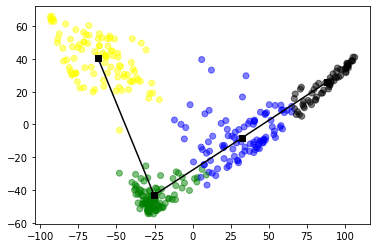

In [40]:
#Build trajectory

#Map the clustering results to the gene expression matrix
labels_original = labels_original.reshape(-1,1)
x = X.T
x['cluster'] = labels_original
#Group the gene expression matrix added to the cluster label according to the cluster and name it according to the cluster
groups = x.groupby('cluster')
group_dict = {}

for name, group in groups:
    group_df = pd.DataFrame(group)
    group_dict[str(name)] = group_df

group0 = group_dict['0']
group1 = group_dict['1']
group2 = group_dict['2']
group3 = group_dict['3']

cluster0 = group0.iloc[:,:-1]
cluster1 = group1.iloc[:,:-1]
cluster2 = group2.iloc[:,:-1]
cluster3 = group3.iloc[:,:-1]

#Calculate the similarity of cells within each cluster, and determine the most similar as the starting cluster
#based on sNN

def calculate_intra_cluster_similarity(cluster, k=90):

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(cluster)
    distances, indices = nbrs.kneighbors(cluster)

    sNN = np.zeros((len(cluster), len(cluster)))
    for i, row in enumerate(indices):
        for j, col in enumerate(row):
            if j == 0:
                continue
            common_neighbors = np.intersect1d(indices[i][1:], indices[col][1:])
            sNN[i][col] = len(common_neighbors)
            sNN[col][i] = sNN[i][col]

    for j in range(len(sNN)):
        for k in range(j, len(sNN)):
            if j != k:
                sNN[k, j] = 0

    intra_cluster_similarity = sNN.mean()
    return intra_cluster_similarity

intra_cluster_similarity0 = calculate_intra_cluster_similarity(cluster0,k=11)
intra_cluster_similarity1 = calculate_intra_cluster_similarity(cluster1,k=11)
intra_cluster_similarity2 = calculate_intra_cluster_similarity(cluster2,k=11)
intra_cluster_similarity3 = calculate_intra_cluster_similarity(cluster3,k=11)
print(intra_cluster_similarity0)
print(intra_cluster_similarity1)
print(intra_cluster_similarity2)
print(intra_cluster_similarity3)

#Preliminary linear trajectory construction using minimum spanning tree
#Construction of initial cluster trajectories
cluster_num = 4 # the choice is based on original work
predicted_clusters = labels_original
csr_fcc = kneighbors_graph(center, n_neighbors= cluster_num, mode= 'distance', include_self=True)

csr_mst = minimum_spanning_tree(csr_fcc)
csr_mst.toarray()    

#visualization of the mst
colors = ListedColormap(['yellow', 'green', 'black', 'blue'])
# visualization of cells using their first two princiapal components and coloring them according to their clusters
plt.scatter(data2[:,0], data2[:,1], c = predicted_clusters, cmap = colors, alpha = 0.5)

# PCA transformation of cluster centers 
cluster_centers_2 = reduce.transform(center)
plt.scatter(cluster_centers_2 [:,0],cluster_centers_2 [:,1],c = 'black', marker = "s")

# plotting the edges of the mst graph
for i in range(csr_mst.shape[0]):
    for j in range(csr_mst.shape[1]):
        if csr_mst[i,j] != 0:
            plt.plot([cluster_centers_2 [i,0], cluster_centers_2 [j,0]], [cluster_centers_2 [i,1], cluster_centers_2 [j,1]], c='black') # 'black')


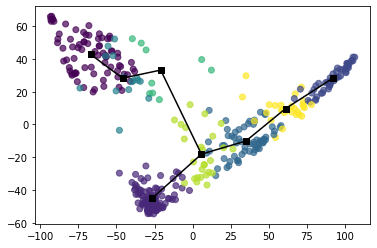

In [41]:
#Add transition cluster trajectory construction

labels = labels.reshape(-1,1)
x_1 = X.T
x_1['cluster'] = labels

groups_1 = x_1.groupby('cluster')
group_1_dict = {}

for name, group in groups_1:
    group_df = pd.DataFrame(group)
    group_dict[str(name)] = group_df

group0 = group_dict['0']
group1 = group_dict['1']
group2 = group_dict['2']
group3 = group_dict['3']
group4 = group_dict['4']
group6 = group_dict['6']
group8 = group_dict['8']
group9 = group_dict['9']

cluster0 = group0.iloc[:,:-1]
cluster1 = group1.iloc[:,:-1]
cluster2 = group2.iloc[:,:-1]
cluster3 = group3.iloc[:,:-1]
cluster4 = group4.iloc[:,:-1]
cluster6 = group6.iloc[:,:-1]
cluster8 = group8.iloc[:,:-1]
cluster9 = group9.iloc[:,:-1]


cluster_centers = []
cluster_matrix_0 = np.array(cluster0)
cluster_matrix_1 = np.array(cluster1)
cluster_matrix_2 = np.array(cluster2)
cluster_matrix_3 = np.array(cluster3)
cluster_matrix_4 = np.array(cluster4)
cluster_matrix_6 = np.array(cluster6)
cluster_matrix_8 = np.array(cluster8)
cluster_matrix_9 = np.array(cluster9)

cluster_center_0 = np.mean(cluster_matrix_0, axis=0)
cluster_center_1 = np.mean(cluster_matrix_1, axis=0)
cluster_center_2 = np.mean(cluster_matrix_2, axis=0)
cluster_center_3 = np.mean(cluster_matrix_3, axis=0)
cluster_center_4 = np.mean(cluster_matrix_4, axis=0)
cluster_center_6 = np.mean(cluster_matrix_6, axis=0)
cluster_center_8 = np.mean(cluster_matrix_8, axis=0)
cluster_center_9 = np.mean(cluster_matrix_9, axis=0)

center_new = np.vstack((cluster_center_0,cluster_center_1,cluster_center_2,cluster_center_3,cluster_center_4,cluster_center_6,cluster_center_8,cluster_center_9))

cluster_num = 8 # the choice is based on original work

predicted_clusters = labels
csr_fcc = kneighbors_graph(center_new, n_neighbors= 4, mode= 'distance', include_self=True)
csr_mst = minimum_spanning_tree(csr_fcc)
csr_mst.toarray()  

#visualization of the mst
# visualization of cells using their first two princiapal components and coloring them according to their clusters
plt.scatter(data2[:,0], data2[:,1], c = predicted_clusters, alpha = 0.7)
# PCA transformation of cluster centers 
cluster_centers_2 = reduce.transform(center_new)
plt.scatter(cluster_centers_2[:,0],cluster_centers_2[:,1],c = 'black', marker = "s")

# plotting the edges of the mst graph
for i in range(csr_mst.shape[0]):
    for j in range(csr_mst.shape[1]):
        if csr_mst[i,j] != 0:
            plt.plot([cluster_centers_2[i,0], cluster_centers_2[j,0]], [cluster_centers_2[i,1], cluster_centers_2[j,1]], c='black') # 'black')


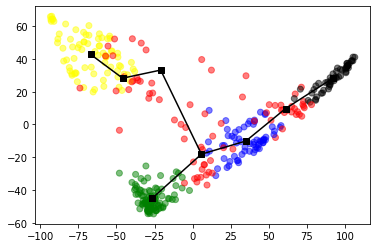

In [42]:
#Visualize fuzzy cell clusters (transition clusters)
#visualization of the mst
colors = ListedColormap(['yellow', 'green', 'black', 'blue','red'])
# visualization of cells using their first two princiapal components and coloring them according to their clusters
predicted_clusters = labels_c
plt.scatter(data2[:,0], data2[:,1], c = predicted_clusters, cmap= colors,alpha = 0.5)

# PCA transformation of cluster centers 
cluster_centers_2 = reduce.transform(center_new)
plt.scatter(cluster_centers_2[:,0],cluster_centers_2[:,1],c = 'black', marker = "s")

# plotting the edges of the mst graph
for i in range(csr_mst.shape[0]):
    for j in range(csr_mst.shape[1]):
        if csr_mst[i,j] != 0:
            plt.plot([cluster_centers_2[i,0], cluster_centers_2[j,0]], [cluster_centers_2[i,1], cluster_centers_2[j,1]], c='black') # 'black')


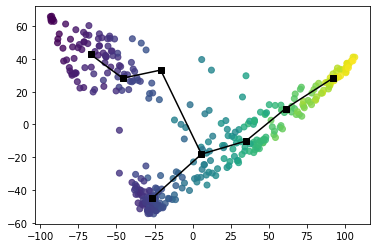

In [43]:
#Calculate pseudo-time
df_norm = np.log2(df+1)
mean_expr = np.mean(df_norm.values, axis=0)
std_expr = np.std(df_norm.values, axis=0)
z_score = (df_norm.values - mean_expr) / std_expr
pca = PCA(n_components=z_score.shape[0])
pca.fit(z_score)
pseudotime = np.dot(z_score, pca.components_[0])
pseudotime_norm = (pseudotime - np.min(pseudotime)) / (np.max(pseudotime) - np.min(pseudotime))
#visualization of the mst
# visualization of cells using their first two princiapal components and coloring them according to their clusters
plt.scatter(data2[:,0], data2[:,1], c = pseudotime_norm, alpha = 0.8)

# PCA transformation of cluster centers 
cluster_centers_2 = reduce.transform(center_new)
plt.scatter(cluster_centers_2[:,0],cluster_centers_2[:,1],c = 'black', marker = "s")

# plotting the edges of the mst graph
for i in range(csr_mst.shape[1]):
    for j in range(csr_mst.shape[0]):
        if csr_mst[i,j] != 0:
            plt.plot([cluster_centers_2[i,0], cluster_centers_2[j,0]], [cluster_centers_2[i,1], cluster_centers_2[j,1]], c='black') # 'black')
